In [1]:
#all the spark includes goes here!

from pyspark.sql import functions as F, Window
from pyspark.sql.types import StringType, IntegerType, BooleanType,DoubleType


In [2]:
#regular python includes goes in here!

import os
import re
regnskabsData = "/home/sidsel/workspace/sparkdata/parquet/alleregnskaber.parquet"

import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import numpy as np
%matplotlib inline

In [3]:
regnskabsDf = sqlContext.read.parquet(regnskabsData)

In [4]:
#regnskabsDf.show()
#signs
#aRegnskabsDf.show()
#sc.broadcast()

In [5]:
def toChar(x):
    return chr(int(x))

charUdf = F.udf(lambda x: toChar(x),StringType())

signs = (regnskabsDf
           .select(F.regexp_extract(F.col("Value"),r"&#\d{1,3};",0).alias("Value"))
           .withColumn(col=charUdf(F.regexp_extract(F.col("Value"),"\d{1,3}",0)),colName="newVal")
           .filter(F.col("Value") != "")
           .dropDuplicates()
           .rdd
           .collectAsMap()
)

broadSigns = sc.broadcast(signs)

In [6]:
def replaceStuff(str):

    try:
        findings = re.findall(r'&#\d{1,3};',str)
        #findings = re.search(r'&#\d{1,3};',str)
        #print(findings)
        if findings is not None:
            for f in findings:
                str = str.replace(f,broadSigns.value[f])
        return str
    except:
        return str
        #return str
        
replaceUDf = F.udf(lambda x: replaceStuff(x),StringType())

In [7]:
aRegnskabsDf = regnskabsDf.withColumn("Value",replaceUDf(F.col("Value")))


In [8]:
powUdf = F.udf(lambda x,y: float(x) if y != None and np.abs(y) < 10 else x,DoubleType())

In [9]:
#extract turnover just to see? 
isTurnoverPresent = F.regexp_extract(F.col("Name"),r"Turnover|Revenue|GrossResult|GrossProfitLoss",0)

turnoverDf = (aRegnskabsDf
              .select('*')
              .withColumn("Turnover",F.when(isTurnoverPresent == "",0).otherwise(1))
              .filter(F.col("TurnOver") == 1)
              .withColumn("Name",F.regexp_replace(pattern=r'\w+\W',replacement="",str="Name"))
              .filter(F.col("Name") != "DescriptionOfMethodsOfRecognitionAndMeasurementBasisOfGrossProfitLoss")
              .filter(F.col("Name") != "DescriptionOfMethodsOfRecognitionAndMeasurementBasisOfRevenue")
              .filter(F.col("Name") != "DisclosureOfGrossProfitLoss")
              .filter(F.col("Name") != "DisclosureOfRevenue")
              .withColumn("Value",F.regexp_replace(pattern=",",replacement="",str=F.col("Value")).cast("float"))
              #.withColumn("Value",powUdf(F.col("Value"),F.col("Dec").cast("float")) )
              .dropDuplicates()
              .drop("Lang")
              #.drop("Dec")
              #.drop("Prec")
              .drop("originalLength")
              .drop("TurnOver")
              .cache()
             )
turnoverDf.show(5)

+-----------+---+----+-------+----------+----------------+----------+-----------+-------------+--------------------+
|       Name|Dec|Prec|unitRef|contextRef|EntityIdentifier|     Start|End_Instant|        Value|          Dimensions|
+-----------+---+----+-------+----------+----------------+----------+-----------+-------------+--------------------+
|    Revenue| -3|null|    EUR|  45349918|        45349918|2013-01-01| 2013-12-31| 1.13084403E9|[cmn:Consolidated...|
|GrossResult| -3|null|    DKK|  26559243|        26559243|2012-01-01| 2012-12-31|   -1542000.0|                  []|
|    Revenue| -3|null|    DKK|  16064939|        16064939|2013-01-01| 2013-12-31|  8.7264602E8|                  []|
|    Revenue| -6|null|    DKK|  15453613|        15453613|2015-01-01| 2015-12-31|1.49810002E10|[cmn:Consolidated...|
|    Revenue| -6|null|    DKK|  16993085|        16993085|2014-10-01| 2015-09-30| 3.50700006E9|[cmn:Consolidated...|
+-----------+---+----+-------+----------+----------------+------

In [10]:
mappedCols = turnoverDf.select("Name").distinct().rdd.map(lambda x: x["Name"]).collect()

In [11]:
excluded = ["Dec","Prec","Lang"]
groupCols = ["unitRef","contextRef","EntityIdentifier","Start","End_Instant","Dimensions"]
maxStruct = F.struct(F.col("count"),F.col("Value"))
pivotCols = [x for x in mappedCols]

In [12]:
pivotDf = (turnoverDf
           .groupBy(*turnoverDf.columns)
           .count()
           .groupBy(*groupCols)
           .pivot("Name",mappedCols)
           .agg(F.max(maxStruct))
           .select(groupCols+[F.col(x+".Value").alias(x) for x in pivotCols])
           .orderBy("EntityIdentifier"))

In [13]:
pivotDf.show(5,truncate=False)
#pivotDf.printSchema()

+-------+----------+----------------+----------+-----------+----------+-----------+---------------+-----------------------------------------+----------------+-------+---------------------------------+
|unitRef|contextRef|EntityIdentifier|Start     |End_Instant|Dimensions|GrossResult|GrossProfitLoss|GrossProfitLossFromDiscontinuedOperations|EmployeeTurnover|Revenue|RevenueFromDiscontinuedOperations|
+-------+----------+----------------+----------+-----------+----------+-----------+---------------+-----------------------------------------+----------------+-------+---------------------------------+
|DKK    |00214239  |214239          |2013-04-01|2014-03-31 |[]        |null       |361353.0       |null                                     |null            |null   |null                             |
|DKK    |00214239  |214239          |2012-04-01|2013-03-31 |[]        |null       |358000.0       |null                                     |null            |null   |null                          

In [14]:
def containsConsolidated(col):
    try:
        for c in col:
            #print(c)
            searched = re.search(r"Consolidated",c)
            if searched.group(0):
                return True
        return False
    except AttributeError as ae:
        return False

checkConsolidatedUdf = F.udf(lambda x: containsConsolidated(x),BooleanType())

rankWindows = (Window
               .partitionBy(F.col("EntityIdentifier"))
               .orderBy(F.col("End_Instant").asc())
              )

def showCorrelationMatrix(pdf):
    axes = pd.tools.plotting.scatter_matrix(pdf,alpha=0.5,figsize=[9,9])
    [plt.setp(item.yaxis.get_majorticklabels(), 'size', 6) for item in axes.ravel()]

    #x ticklabels
    [plt.setp(item.xaxis.get_majorticklabels(), 'size', 6) for item in axes.ravel()]
    [plt.setp(item.yaxis.get_label(), 'size', 6) for item in axes.ravel()]

    #x labels
    [plt.setp(item.xaxis.get_label(), 'size', 6) for item in axes.ravel()]
    plt.show()

In [15]:
#noConsolidatedDf.show()

In [16]:
#take out consolidated posts. 
noConsolidatedDf = (pivotDf
                    .select('*')
                    .filter(F.col("unitRef") == "DKK")
                    .filter(checkConsolidatedUdf(F.col("Dimensions")) != True)
                    .withColumn("rank",F.rank().over(rankWindows))
                    .withColumnRenamed(existing="EntityIdentifier",new="cvr")
                    .orderBy("cvr","rank")
                    )
#Show'em 
noConsolidatedDf.show(5)
describeCols = mappedCols+[F.year(F.col("Start")).alias("Year")]

#Show'em summary stats
(noConsolidatedDf
 .select(describeCols)
 .describe()
 .show()
)

+-------+----------+--------+----------+-----------+----------+-----------+---------------+-----------------------------------------+----------------+-------+---------------------------------+----+
|unitRef|contextRef|     cvr|     Start|End_Instant|Dimensions|GrossResult|GrossProfitLoss|GrossProfitLossFromDiscontinuedOperations|EmployeeTurnover|Revenue|RevenueFromDiscontinuedOperations|rank|
+-------+----------+--------+----------+-----------+----------+-----------+---------------+-----------------------------------------+----------------+-------+---------------------------------+----+
|    DKK|  00214239|  214239|2012-04-01| 2013-03-31|        []|       null|       358000.0|                                     null|            null|   null|                             null|   1|
|    DKK|  00214239|  214239|2013-04-01| 2014-03-31|        []|       null|       361353.0|                                     null|            null|   null|                             null|   2|
|    DKK| 

In [17]:
noConsolidatedDf.groupBy("unitRef").count().show()

+-------+------+
|unitRef| count|
+-------+------+
|    DKK|857252|
+-------+------+



In [18]:
def partitionPerYear(Df, Year):
    return Df.filter(F.year("Start") == Year)


Based on the summery stats, we can see that: GrossProfitLossFromDiscontinuedOperations and RevenueFromDiscontinuedOperations shouldn't be regarded as variables, since they only have 2 and 24 points

We also take out outliers in years. 

#### First look at the data 
lets take a look at the correlation between these forms of revenue / profit / etc. combined with year. without other limitations. 


/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_base.py:2903: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=2015.0, right=2015.0
  'left=%s, right=%s') % (left, right))
/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_base.py:3179: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=2015.0, top=2015.0
  'bottom=%s, top=%s') % (bottom, top))


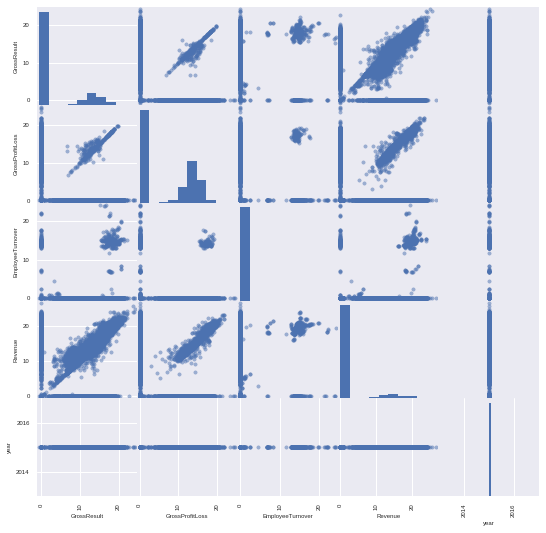

In [25]:

removeSmallAmountcols = ["GrossProfitLossFromDiscontinuedOperations","RevenueFromDiscontinuedOperations"]
includedCols = [F.log1p(f).alias(f) for f in mappedCols if f not in removeSmallAmountcols]+[F.year("Start").alias("year")]



filteredOutliersDf = (noConsolidatedDf
                      .select([i for i in noConsolidatedDf.columns if i not in removeSmallAmountcols])
                      .filter((F.year("Start") >= 2010) & (F.year("Start") < 2016))
                      .na # values that aren't there are pr. default set to 0
                      .fill(0.0,subset=[x for x in mappedCols if x not in removeSmallAmountcols])
                     )

filteredOutliersDfYear = partitionPerYear(filteredOutliersDf, 2015)

showCorrelationMatrix(filteredOutliersDfYear.select(includedCols).toPandas())



Kig på branchefordeling mht employeeTurnover...

Mht indsustri 

profitloss pr ansat, se om der er en udvikling.

Undersøg udviklingen ift. hvilke brancher der stikker af. Hvordan er udviklingen pr år?


In [20]:
notloggedCols = [f for f in mappedCols if f not in removeSmallAmountcols]+[F.year("Start").alias("year")]

+--------+-------+----------+----------+-----------+----------+-----------+---------------+----------------+-------+----+
|     cvr|unitRef|contextRef|     Start|End_Instant|Dimensions|GrossResult|GrossProfitLoss|EmployeeTurnover|Revenue|rank|
+--------+-------+----------+----------+-----------+----------+-----------+---------------+----------------+-------+----+
|10000025|    DKK|  10000025|2012-01-01| 2012-12-31|        []|        0.0|       -17101.0|             0.0|    0.0|   1|
|10000025|    DKK|  10000025|2013-01-01| 2013-12-31|        []|   -24353.0|       -24353.0|             0.0|    0.0|   2|
|10000025|    DKK|  10000025|2014-01-01| 2014-12-31|        []|   -47427.0|            0.0|             0.0|    0.0|   3|
|10000025|    DKK|  10000025|2015-01-01| 2015-12-31|        []|  -174675.0|            0.0|             0.0|    0.0|   4|
|10000157|    DKK|  10000157|2012-01-01| 2012-12-31|        []|   -39000.0|            0.0|             0.0|    0.0|   1|
+--------+-------+------

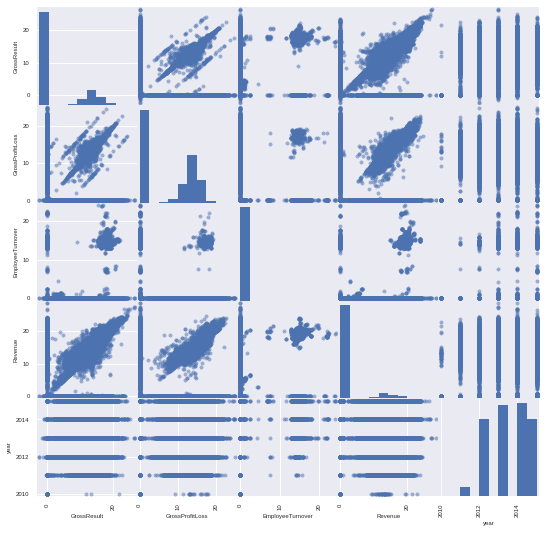

In [21]:
#Extract cvrNumbers that has more than 2 posts
aboveDf = (filteredOutliersDf
           .groupBy("cvr")
           .agg(F.max("rank").alias("rank"))
           .filter(F.col("rank") > 2) #this is slacked since we'll loose some.
           .drop("rank")
           .join(filteredOutliersDf,on=("cvr"),how="inner")
           .orderBy("cvr","rank")
           .cache()
          )

aboveDf.show(5)
showCorrelationMatrix(aboveDf.select(includedCols).toPandas())

In [22]:
aboveDf.select("cvr").distinct().count()

189050

In [23]:
def createValsForGazeller(df,col,limit):
    '''
        Identifies 
    '''
    rankedWind = Window.partitionBy(F.col("cvr")).orderBy(F.col("End_Instant"))
    
    revenueDf = (df
                 .select("cvr",col,"End_Instant")
                 .filter((F.col(col) >= limit)) #another criterion revenue must be above 1.000.000 or 500k
                 .drop(col)
                 .distinct()
                 .join(df,("cvr","End_Instant"),"inner")
                 .cache()
                )
    
    mustNeverBeSmallerWindow = (Window.partitionBy("cvr").orderBy("End_Instant"))
    
    percent = (F.col(col)-F.first(F.col(col)).over(mustNeverBeSmallerWindow))/F.first(F.col(col)).over(mustNeverBeSmallerWindow)

    #Lets  compute the revenue...
    return (df
            .select("cvr","contextRef",col,"End_Instant")
            .withColumn("Lagged"+str(col),F.col(col)-F.lag(F.col(col)).over(mustNeverBeSmallerWindow))
            .withColumn("FactorSinceStart",percent)
            .na
            .fill(0.0)
           )
    
    
def isGazelle(df,col,limit):
    
    rankedWind = Window.partitionBy(F.col("cvr")).orderBy(F.col("End_Instant"))
    
    #first criterion:
    nonNegativeDF = (df
                     .filter(F.col("Lagged"+str(col)) < 0.0)
                     .select("cvr")
                     .distinct()
                    )
    
    firstOverLimitDf = (df
                        .withColumn("rank",F.rank().over(rankedWind))
                        .select(F.col("cvr"))
                        .distinct()
                       ) # removes the cvr's that start with smaller values than the limit, fit nicely with the fact that we can't have negative growht in the period
    
    return(df
           .select("cvr")
           .distinct()
           .subtract(nonNegativeDF)
           .subtract(firstOverLimitDf)
           .join(df,("cvr"),"inner")
           .filter(F.col("FactorSinceStart") >= 1.0)
           .select("cvr")
           .join(df,("cvr"),"inner")
           .dropDuplicates()
           
           .orderBy("cvr","End_Instant",F.col("FactorSinceStart").desc())
          )

In [24]:
grossProfitLossGazellerDf = createValsForGazeller(aboveDf,"GrossResult",500000) # for grossprofitloss we have 500k

AssertionError: on should be Column or list of Column

In [ ]:
grossProfitLossGazellerDf.show()

In [ ]:
windowMax = (Window.orderBy(F.col("FactorSinceStart").desc()).partitionBy("cvr"))
gazelleGrossDf = isGazelle(grossProfitLossGazellerDf,"GrossResult",500000)
print(gazelleGrossDf.select("cvr").distinct().count())

orderedGazellerDf = (gazelleGrossDf
                     .withColumn("max",F.max("FactorSinceStart").over(windowMax))
                     .orderBy(F.col("max").desc(),F.col("End_Instant"))
                     .cache()
                     )

orderedGazellerDf.show()

In [ ]:
rankedWindow = Window.orderBy("max")

plttedGross = (orderedGazellerDf
               .select("cvr",F.col("max").alias("max"))
               .distinct()
               .withColumn("rank",F.row_number().over(rankedWindow))
              )
plttedGross.show()
plttedGross.orderBy(F.col("rank").desc()).show()

In [ ]:
sb.barplot(x="rank",y="max",data=plttedGross.toPandas())

In [ ]:
gazelleRevenueDf = createValsForGazeller(aboveDf,"Revenue",1000000) # for revenue we have 1000k
gazelleRevenueDf.show()

In [ ]:
gazelleGrossDf = isGazelle(gazelleRevenueDf,"Revenue",1000000)

In [ ]:
gazelleGrossDf.show()

### Next up:byg en regressionsmodel over gazellerne...


    
* Ide: Kig på gæld, indrag gæld som en feature.
* Ide: Kig på aktiver. Hvilke aktiver skal medtages, hvilke henvender sig især til Revenue og Bruttoresultat?
* Ide: Det kigger vi på? 


Giv Andreas Aarhus en gazelle liste.




In [ ]:
gazelleGrossDf.show()